## Model 1: Policy simulation

The objective of this model-based simulation is to analyse the impact of policy, technology, and commodity changes on consumer price inflation in selected countries. The simulation environment is learnt from real data, after which simulations using synthetic data are used to do policy analysis by manipulating a number of selected variables such as government debt, cellular subscription, gdp growth, and real interest rates in the synthetic data. A secondary purpose of the simulation model is to identify and map the interactions between world-level and country-level indicator variables.

#### Features
------------

Multivariate human and technological development indicator timeseries
1. aggregated across nations using hand-crafted rules.
2. raw, collected on a per-country level.

#### Labels
----------

Consumer price inflation levels for the following countries:

* Singapore
* Switzerland
* Netherlands
* Japan
* France
* United States
* China
* India
* Brazil
* Colombia
* Indonesia
* Senegal
* Ghana

#### Training
------------

Training is done on a feature - single country basis.

### Load and prepare the data

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from tensorflow import keras

%matplotlib inline

In [2]:
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:20,.4f}'.format

In [3]:
sns.set_style("whitegrid")
sns.set_palette("colorblind")

In [4]:
country = 'Singapore'

In [5]:
country_labels = ['Brazil', 'China', 'Colombia', 'France', 'Ghana', 'India', 'Indonesia', 'Japan', 'Netherlands',
                  'Senegal', 'Singapore', 'Switzerland', 'United States']

In [6]:
assert country in country_labels

#### Load and combine the features and labels

In [7]:
features_df = pd.read_csv('features/m_one/world_aggregate.csv', sep=';', header=0)
labels_df = pd.read_csv('features/m_one/labels_interpolated.csv', sep=';', header=0)

In [8]:
features_df.head()

,date,bank capital to assets ratio,bank nonperforming loans,cereal yield,energy imports,food exports,high-tech exports,inflation,lending interest rate,life expectancy,...,electricity access,co2 emissions,electricity consumption,mobile subscriptions,newborns,overweight,rural population,unemployed,urban population,workers
0,1960-01-01,0.0000,0.0000,0.0000,0.0517,0.0000,0.0000,0.0000,0.0019,45.2673,...,0.0000,2.1968,0.4982,0.0000,0.0318,0.0000,0.6634,0.0014,0.3362,0.0232
1,1960-02-01,0.0000,0.0000,0.0000,0.0517,0.0000,0.0000,0.0000,0.0019,45.3268,...,0.0000,2.1920,0.5003,0.0000,0.0317,0.0000,0.6630,0.0014,0.3367,0.0232
2,1960-03-01,0.0000,0.0000,0.0000,0.0518,0.0000,0.0000,0.0000,0.0019,45.3863,...,0.0000,2.1872,0.5024,0.0000,0.0316,0.0000,0.6626,0.0014,0.3371,0.0232
3,1960-04-01,0.0000,0.0000,0.0000,0.0519,0.0000,0.0000,0.0000,0.0019,45.4458,...,0.0000,2.1825,0.5045,0.0000,0.0316,0.0000,0.6622,0.0015,0.3375,0.0232
4,1960-05-01,0.0000,0.0000,0.0000,0.0520,0.0000,0.0000,0.0000,0.0019,45.5052,...,0.0000,2.1777,0.5066,0.0000,0.0315,0.0000,0.6617,0.0015,0.3379,0.0232


In [9]:
labels_df.head()

,date,Brazil,China,Colombia,France,Ghana,India,Indonesia,Japan,Netherlands,Senegal,Singapore,Switzerland,United States
0,1960-01-01,0.0000,0.0000,0.0581,0.0414,0.0000,0.0178,0.3959,0.0357,0.0232,0.0000,0.0000,0.0144,0.0146
1,1960-02-01,0.0000,0.0000,0.0602,0.0399,0.0000,0.0178,0.3743,0.0372,0.0224,0.0000,0.0003,0.0147,0.0143
2,1960-03-01,0.0000,0.0000,0.0623,0.0385,0.0000,0.0178,0.3527,0.0387,0.0215,0.0000,0.0007,0.0151,0.0139
3,1960-04-01,0.0000,0.0000,0.0643,0.0371,0.0000,0.0178,0.3312,0.0402,0.0207,0.0000,0.0010,0.0154,0.0136
4,1960-05-01,0.0000,0.0000,0.0664,0.0356,0.0000,0.0177,0.3096,0.0417,0.0199,0.0000,0.0013,0.0157,0.0133


In [10]:
combined_df = pd.concat([features_df, labels_df.drop(columns=['date'])], axis=1)

In [11]:
combined_df.head()

,date,bank capital to assets ratio,bank nonperforming loans,cereal yield,energy imports,food exports,high-tech exports,inflation,lending interest rate,life expectancy,...,France,Ghana,India,Indonesia,Japan,Netherlands,Senegal,Singapore,Switzerland,United States
0,1960-01-01,0.0000,0.0000,0.0000,0.0517,0.0000,0.0000,0.0000,0.0019,45.2673,...,0.0414,0.0000,0.0178,0.3959,0.0357,0.0232,0.0000,0.0000,0.0144,0.0146
1,1960-02-01,0.0000,0.0000,0.0000,0.0517,0.0000,0.0000,0.0000,0.0019,45.3268,...,0.0399,0.0000,0.0178,0.3743,0.0372,0.0224,0.0000,0.0003,0.0147,0.0143
2,1960-03-01,0.0000,0.0000,0.0000,0.0518,0.0000,0.0000,0.0000,0.0019,45.3863,...,0.0385,0.0000,0.0178,0.3527,0.0387,0.0215,0.0000,0.0007,0.0151,0.0139
3,1960-04-01,0.0000,0.0000,0.0000,0.0519,0.0000,0.0000,0.0000,0.0019,45.4458,...,0.0371,0.0000,0.0178,0.3312,0.0402,0.0207,0.0000,0.0010,0.0154,0.0136
4,1960-05-01,0.0000,0.0000,0.0000,0.0520,0.0000,0.0000,0.0000,0.0019,45.5052,...,0.0356,0.0000,0.0177,0.3096,0.0417,0.0199,0.0000,0.0013,0.0157,0.0133


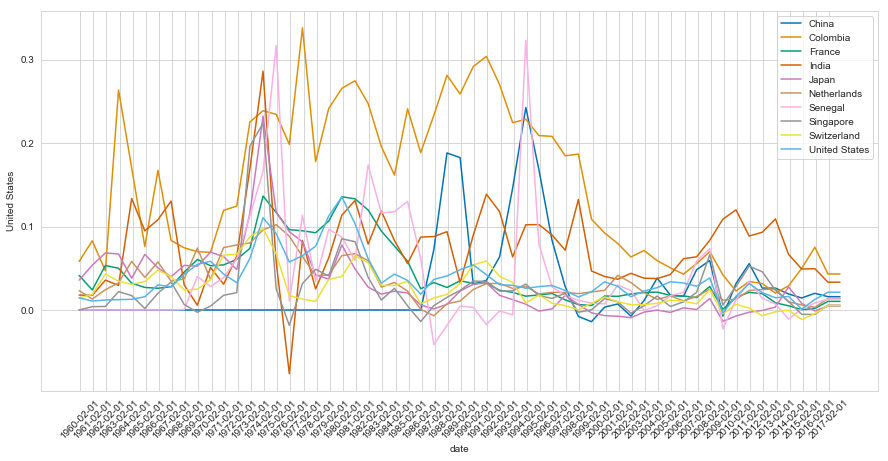

In [12]:
fig, ax = plt.subplots(figsize=(15,7))
[sns.lineplot(x='date', y=c, markers=True, ax=ax, label=c, data=combined_df) for c in list(filter(lambda x: x not in ['Brazil', 'Indonesia', 'Ghana'], country_labels))]

xticks=ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i % 12 == 1:
        xticks[i].set_visible(True)
    else:
        xticks[i].set_visible(False)

ax.set_xticklabels(combined_df['date'], rotation=45);

In [13]:
combined_df.columns

Index(['date', 'bank capital to assets ratio', 'bank nonperforming loans',
       'cereal yield', 'energy imports', 'food exports', 'high-tech exports',
       'inflation', 'lending interest rate', 'life expectancy',
       'population density', 'real interest rate', 'broad money',
       'exports of goods and services', 'gross domestic savings',
       'high-tech value added', 'household consumption expenditure',
       'imports of goods and services', 'listed companies',
       'manufacturing value added', 'r and d spend', 'services trade', 'trade',
       'government debt service', 'government interest payments external debt',
       'government tax revenue', 'birth deaths', 'broadband subscriptions',
       'electricity access', 'co2 emissions', 'electricity consumption',
       'mobile subscriptions', 'newborns', 'overweight', 'rural population',
       'unemployed', 'urban population', 'workers', 'Brazil', 'China',
       'Colombia', 'France', 'Ghana', 'India', 'Indonesia', 'Japa

### Prepare the country features

In [14]:
base_feature_df = combined_df[['bank capital to assets ratio', 'bank nonperforming loans', 'cereal yield',
                               'energy imports', 'food exports', 'high-tech exports', 'inflation',
                               'lending interest rate', 'life expectancy', 'population density', 'real interest rate',
                               'broad money', 'exports of goods and services', 'gross domestic savings',
                               'high-tech value added', 'household consumption expenditure',
                               'imports of goods and services', 'listed companies', 'manufacturing value added',
                               'r and d spend', 'services trade', 'trade', 'government debt service',
                               'government interest payments external debt', 'government tax revenue', 'birth deaths',
                               'broadband subscriptions', 'electricity access', 'co2 emissions',
                               'electricity consumption', 'mobile subscriptions', 'newborns', 'overweight',
                               'rural population', 'unemployed', 'urban population', 'workers', country]]

In [15]:
base_feature_df.to_csv('features/m_one/combined_%s.csv' % country.lower(), sep=',', index=False)

In [16]:
base_feature_df['label'] = base_feature_df[country].shift(periods=1)
base_df = base_feature_df.drop(country, axis=1).fillna(0.00);

In [17]:
num_obs = len(base_df)
num_cols = len(base_df.columns)
num_features = len(base_df.columns) - 1

### Model iterations
---------------------

### Exploration 1

**Multivariate LSTM** fitted on the real data, see https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
- Activation function: Leaky ReLU.
- Loss function: mean squared error.
- Optimizer: adam.
- Num observations source dataset: 684 (using lagshift, 1960-2016 inclusive monthly)
- Num sequences (@ sequence length 6): 116.
- Batch size: 4-8 sequences (although `size=48` would lead to more stable training)

In [18]:
from keras import Sequential
from keras.layers import LSTM, Dense, LeakyReLU
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [19]:
lstm_params = {
   'sequence_length': 4,
   'batch_size': 8,
   'num_epochs': 600,
   'num_units': 128,
   'lrelu_alpha': 0.3
}

#### LSTM features

In [20]:
features = []
labels = []

for i in range(int(num_obs / lstm_params['sequence_length'])):
    labels_df = base_df['label']
    labels.append(labels_df[i:(i+lstm_params['sequence_length'])].values[-1:])
    features.append(base_df[i:(i+lstm_params['sequence_length'])].values)

In [21]:
lstm_train_X = np.asarray(features[0:100])
lstm_train_X = lstm_train_X.reshape((lstm_train_X.shape[0], lstm_params['sequence_length'], num_cols))
lstm_train_y = np.asarray(labels[0:100])
lstm_train_y = lstm_train_y.reshape((lstm_train_y.shape[0]))

In [22]:
lstm_test_X = np.asarray(features[100:])
lstm_test_X = lstm_test_X.reshape((lstm_test_X.shape[0], lstm_params['sequence_length'], num_cols))
lstm_test_y = np.asarray(labels[100:])
lstm_test_y = lstm_test_y.reshape((lstm_test_y.shape[0]))

In [23]:
X = np.asarray(features)
X = X.reshape((X.shape[0], lstm_params['sequence_length'], num_cols))
y = np.asarray(labels)
y = y.reshape((y.shape[0], 1))

In [24]:
print('X: %s, y: %s' % (X.shape, y.shape))

X: (174, 4, 38), y: (174, 1)


#### Model: LSTM

In [25]:
model = Sequential()
model.add(LSTM(lstm_params['num_units'], input_shape=(lstm_params['sequence_length'], num_cols)))
model.add(Dense(1, activation=LeakyReLU(alpha=lstm_params['lrelu_alpha'])))
model.compile(loss='mse', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               85504     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 85,633
Trainable params: 85,633
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_run = model.fit(lstm_train_X, lstm_train_y, epochs=lstm_params['num_epochs'], batch_size=lstm_params['batch_size'])

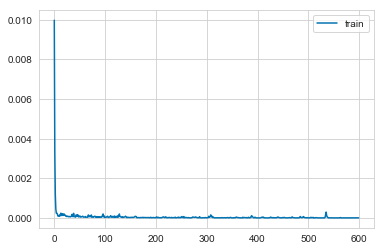

In [27]:
plt.plot(train_run.history['loss'], label='train')
plt.legend()
plt.show()

##### Evaluate model performance

In [28]:
model.evaluate(lstm_test_X, lstm_test_y)

74/74 [==============================] - 0s 2ms/step


0.0007531466198506186

In [29]:
yhat = model.predict(lstm_test_X)

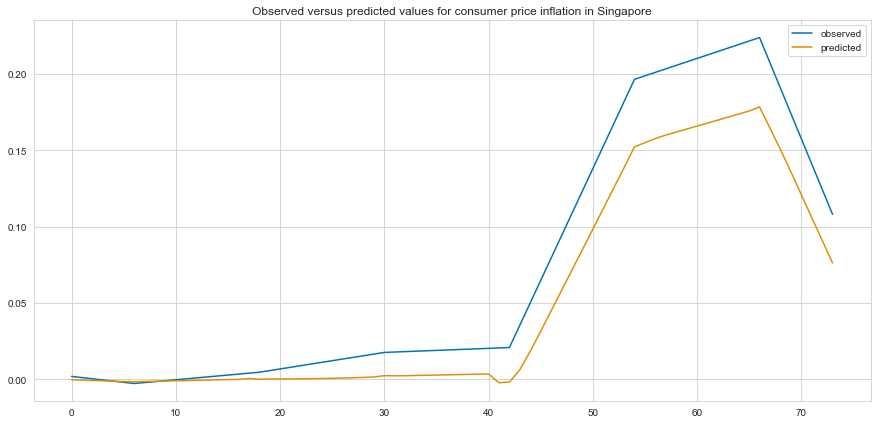

In [30]:
plt.figure(figsize=(15,7))
plt.plot(lstm_test_y, label='observed')
plt.plot(yhat, label='predicted')
plt.legend()
plt.title('Observed versus predicted values for consumer price inflation in %s' % country)
plt.show()

In [31]:
print('rmse: %s\nmean observed: %s\nmean predicted: %s' % (np.sqrt(mean_squared_error(lstm_test_y, yhat)),
                                                           np.mean(lstm_test_y), np.mean(yhat)))

rmse: 0.027443517103336656
mean observed: 0.07313690244342604
mean predicted: 0.05145269


### Exploration 2

**GAN** to generate training data, **LSTM** trained on generated data validated on the real data. See https://arxiv.org/pdf/1706.02633.pdf.

Keras GAN implementation inspired by https://medium.com/@mattiaspinelli/simple-generative-adversarial-network-gans-with-keras-1fe578e44a87

In [32]:
gan_df = base_df
gan_df.shape

(696, 38)

In [33]:
gan_cols = gan_df.shape[1]

In [34]:
gan_params = {
   'num_epochs': 1000,
   'save_interval': 10,
   'sequence_length': 4,
   'num_variables': gan_cols,
   'batch_size': 32,
   'lr': 0.001 
}

In [35]:
generator_params = {
   'noise_sigma': 0.1,
   'lstm_units': 128,
   'lstm_dropout': 0.3,
   'gru_units': 64,
   'lr': 0.001
}

In [61]:
discriminator_params = {
   'bi_lstm_units': 64,
   'dropout_rate': 0.3,
   'lr': 0.001
}

#### GAN input sequences

The collated World Bank and IMF data used as input for the data generator and to validate the model trained on generated data.

In [37]:
gan_features = []
gan_labels = []

for i in range(int(num_obs / gan_params['sequence_length'])):
    gan_labels_df = gan_df['label']
    gan_labels.append(gan_labels_df[i:(i+gan_params['sequence_length'])].values[-1:])
    gan_features.append(gan_df[i:(i+gan_params['sequence_length'])].values)

In [38]:
real = np.asarray(gan_features)
real = real.reshape((real.shape[0], gan_params['sequence_length'], gan_cols))

In [39]:
real.shape

(174, 4, 38)

#### Generator

In [40]:
from keras.layers import GaussianNoise, LSTM, Dropout, BatchNormalization, Dense, LocallyConnected2D, GRU, Reshape

In [41]:
def build_generator(params):
    gshape = params['sequence_length'], params['num_variables']
    generator = Sequential(name='generator')
    generator.add(LSTM(params['lstm_units'], input_shape=(gshape), return_sequences=True))
    generator.add(Dropout(params['lstm_dropout']))
    generator.add(GaussianNoise(stddev=params['noise_sigma']))
    generator.add(BatchNormalization(axis=1, momentum=0.95, epsilon=0.0001))
    generator.add(Dense(params['num_variables'], activation='relu'))
    generator.add(GRU(params['gru_units'], input_shape=(params['sequence_length'], params['num_variables']), return_sequences=True))
    generator.add(Dense(params['num_variables'], activation='softmax'))
    return generator

#### Discriminator

In [42]:
from keras.layers import Bidirectional, LSTM, Dense

In [53]:
def build_discriminator(params):
    dshape = params['sequence_length'], params['num_variables']
    discriminator = Sequential(name='discriminator')
    discriminator.add(Bidirectional(LSTM(params['bi_lstm_units'], input_shape=(dshape))))
    discriminator.add(Dropout(params['dropout_rate']))
    discriminator.add(Dense(1, activation='sigmoid'))
    return discriminator

#### GAN

In [54]:
from keras import Sequential
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

In [ ]:
def gan_loss_function()

In [137]:
def build_gan(gan_params, generator_params, discriminator_params):
    g = build_generator({**gan_params, **generator_params})
    g.compile(loss='binary_crossentropy', optimizer=Adam(lr=generator_params['lr']), metrics=['mae'])
    d = build_discriminator({**gan_params, **discriminator_params})
    d.compile(loss='binary_crossentropy', optimizer=Adam(lr=discriminator_params['lr']), metrics=['binary_accuracy'])
    gan = Sequential(name='gan')
    gan.add(g)
    gan.add(d)
    gan.summary()
    gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=gan_params['lr']), metrics=['mae', 'binary_accuracy'])
    return gan

In [138]:
gan = build_gan(gan_params, generator_params, discriminator_params)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator (Sequential)       (None, 4, 38)             112668    
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 52865     
Total params: 165,533
Trainable params: 165,525
Non-trainable params: 8
_________________________________________________________________


In [139]:
def train_gan(real, batch_size, params):
    g_metrics = []
    d_metrics = []
    
    for i in range(params['num_epochs']):
        generator = gan.get_layer('generator')
        discriminator = gan.get_layer('discriminator')
        
        # Select random samples from the real data as part of the training batch
        random_index = np.random.randint(0, len(real) - batch_size / 2)
        batch_real = real[random_index:int(random_index + batch_size / 2)]
        batch_synth = np.random.rand(int(batch_size / 2), params['sequence_length'], real.shape[2])    
        combined = np.concatenate([batch_real, batch_synth], axis=0)
        disc_labels = np.concatenate([np.ones(int(batch_size / 2)), np.zeros(int(batch_size / 2))], axis=0)
        permutation = np.random.permutation(len(combined))

        # Train the discriminator and generator
        g_metrics.append(generator.train_on_batch(batch_synth, batch_real))
        d_metrics.append(discriminator.train_on_batch(combined[permutation], disc_labels[permutation]))
    return d_metrics, g_metrics

In [140]:
d_metrics, g_metrics = train_gan(real, gan_params['batch_size'], gan_params)

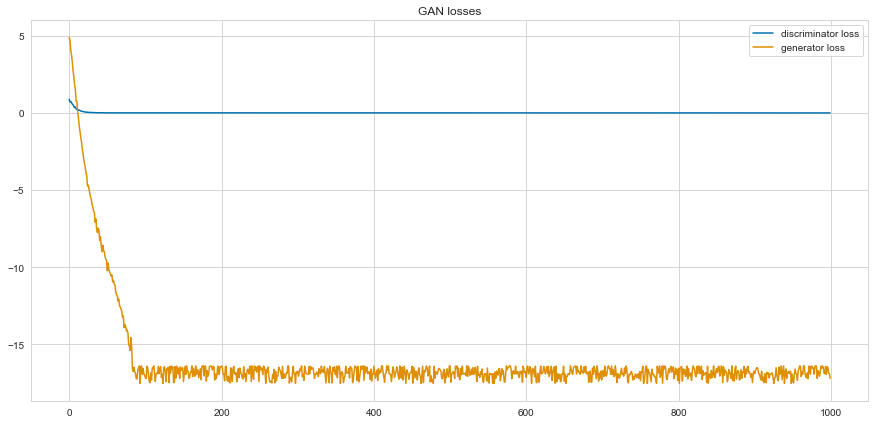

In [141]:
plt.figure(figsize=(15,7))
plt.plot([metrics[0] for metrics in d_metrics], label='discriminator loss')
plt.plot([metrics[0] for metrics in g_metrics], label='generator loss')
plt.legend()
plt.title('GAN losses')
plt.show()

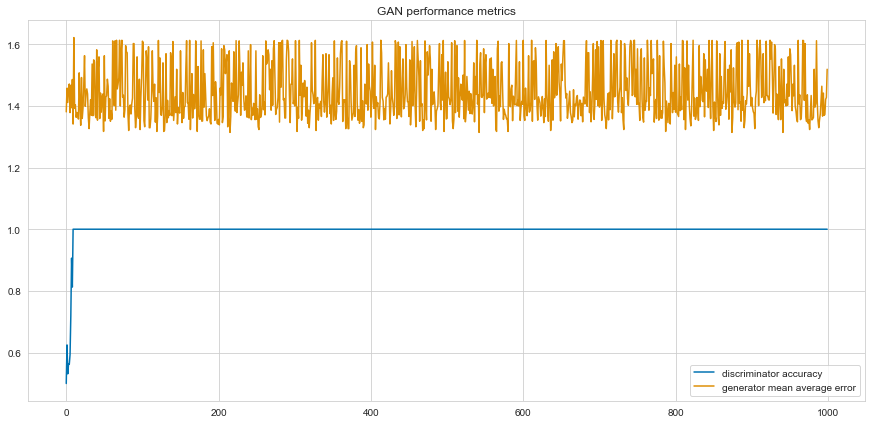

In [142]:
plt.figure(figsize=(15,7))
plt.plot([metrics[1] for metrics in d_metrics], label='discriminator accuracy')
plt.plot([metrics[1] for metrics in g_metrics], label='generator mean average error')
plt.legend()
plt.title('GAN performance metrics')
plt.show()

In [143]:
generated_y = gan.get_layer('generator').predict(np.random.rand(num_obs, gan_params['sequence_length'], gan_cols))[:,-1,-1]
gan_y = gan_df['label'].values

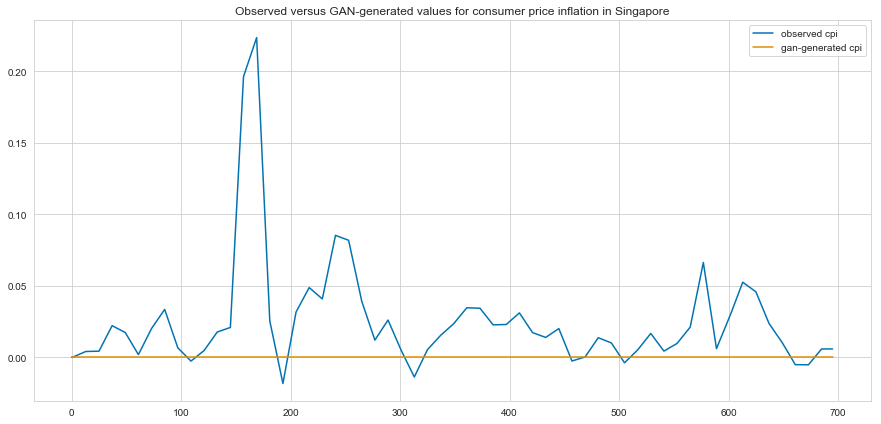

In [144]:
plt.figure(figsize=(15,7))
plt.plot(gan_y, label='observed cpi')
plt.plot(generated_y, label='gan-generated cpi')
plt.legend()
plt.title('Observed versus GAN-generated values for consumer price inflation in %s' % country)
plt.show()

In [145]:
print('rmse: %s\nmean observed: %s\nmean generated: %s' % (np.sqrt(mean_squared_error(gan_y, generated_y)),
                                                           np.mean(gan_y), np.mean(generated_y)))

rmse: 0.044885611906541625
mean observed: 0.02546666163465455
mean generated: 2.9697997e-10


### Exploration 3

**Sequence transformer network** to generate training data, **LSTM** trained on generated data validated on the real data. See https://arxiv.org/abs/1808.06725

## Simulation 1

Question: what happens to consumer price inflation in the long run if the government decides to borrow more money?

##### Simulation parameters
- central government debt
- time horizon

##### Environment variables
- world economy: selected generated macroeconomic indicators
- country economy: selected generated country-level indicators
- hybrid: interaction country x world